# NextFunction and controls

First we will just copy the code for NextClimate. Recall:

`NextClimate: X_climate t -> (CO2_emission_rate, aerosol_injection_rate) -> X_climate (t+Dt)`


Refer to the NextClimate notebook for more details/explanations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#-----------------------------------------------------
# fixed BEAM+Aerosol parameters
#-----------------------------------------------------
ka = 0.2              # 1/years
kd = 0.05             # 1/years
delta = 50            # dimensionless
kH = 1.23E3           # dimensionless
k1 = 8.00E-7          # mol/Kg
k2 = 4.53E-10         # mol/Kg
AM = 1.77E20          # mol
OM = 7.8E22           # mol
Alk = 767.0           # Gt C
GtCtoppm = 0.47       # ppm in atmosphere/ Gt C in atmosphere
Mat2000 = 809         # Gt C
Mup2000 = 725         # Gt C 
Mlo2000 = 35642       # Gt C
# parameters entering temperature computation
# carbon parameters
alpha = 3.8         # Watts / m^2
gamma = 0.3         # Watts / (m^2 * Celcius)
Lambda = 1.3        # Watts / (m^2 * Celcius)
muat = 0.022        # 1/years
mulo = 1/60         # 1/years
MatPreInd = 596     # Gt C
# aerosol parameters (taken from Helwegen2019)
eta = 0.742         # dimensionless
alphaSO2 = 65       # Watts / m^2
betaSO2 = 2246      # Mt of S / year
gammaSO2 = 0.23     # dimensionless
#-----------------------------------------------------
# Euler integrator for carbon cycle eqs
#-----------------------------------------------------
def stepC(t, Mat, Mup, Mlo, CO2_emission_rate):
    dt = 0.05
    # requirements: 0 < dt <= 0.05, Mat > 0, Mup > 0, Mlo > 0, -5 Gt C / year <= CO2_emission_rate <= 50 Gt C / year
    if (Mat > 0 and Mup > 0 and Mlo > 0 and -5 <= CO2_emission_rate <= 50 and 0 < dt <= 0.05):
        flowATtoUP = ka*(Mat - (AM*kH*(1 + delta)
                                 *( - Alk*k1 + 4*Alk*k2 + k1*Mup - 8*k2*Mup 
                   + np.sqrt(k1*(Alk**2 *(k1 - 4*k2) - 2*Alk*(k1 - 4*k2)*Mup + k1*Mup**2))
                                  ))/(2*(k1 - 4*k2)*OM))
        flowUPtoLO = kd*(-(Mlo/delta) + Mup)
        dMat = CO2_emission_rate - flowATtoUP
        dMup = - flowUPtoLO + flowATtoUP
        dMlo = flowUPtoLO
        return t+dt, Mat + dMat*dt, Mup + dMup*dt, Mlo + dMlo*dt
    else: print("ERROR: failure to meet requirements in stepC fuction.")
#-----------------------------------------------------        
# Euler integrator for temperature eqs
#-----------------------------------------------------
def stepT(t, Mat, Tat, Tlo, AerosolInjectionRate):
    dt = 1
    # requirements: Mat> 0,  <= AerosolInjectionRate < 100 Mt S / year
    if (Mat > 0 and 0 <= AerosolInjectionRate < 100):
        if AerosolInjectionRate == 0:
            Teq = (1/ Lambda)*( alpha* np.log2(Mat/MatPreInd) )
        elif AerosolInjectionRate > 0:
            Teq = (1/ Lambda)*( alpha* np.log2(Mat/MatPreInd) - 
                  eta*alphaSO2*np.exp( -np.power(betaSO2/AerosolInjectionRate,gammaSO2) ) )
        flowATtoLO = gamma*(Tat - Tlo)
        dTat = muat*( Lambda*(Teq - Tat) - flowATtoLO)
        dTlo = mulo*flowATtoLO
        return Tat + dTat*dt, Tlo + dTlo*dt
    else: print("ERROR: failure to meet requirements in stepT fuction.")
#-----------------------------------------------------        
# Function to fix tipping points on double fold greenland ice sheet model
#-----------------------------------------------------
def fixDFsteady(Tp,Tm,Vp,Vm):
    global eqrhsICE
    if Tp < Tm or Vp < Vm:
        print('PHYSICAL ERROR: check that Tp > Tm and Vp > Vm\n');
    # set coeffs
    a = 3*(Vp + Vm)/2
    b = - 3*Vp*Vm
    def c(T):
        return ( Tp*Vm**2*(3*Vp-Vm) - Tm*Vp**2*(3*Vm-Vp) + T*(Vm - Vp)**3 ) / (2*(Tp-Tm))
    def eqrhsICE(V,T):
        return - V**3 + a*V**2 + b*V + c(T)
    #computing steady states
    Tflist = np.linspace(0,1.2*Tp,200)
    steadystates = []
    root1 = []
    root2 = []
    root3 = []
    if abs(np.roots([-1,a,b,c(0)])[0] - 1) > 0.05:
        print('ALARM: Check parameter values, the value of roots at Tf = 0 are ', np.roots([-1,a,b,c(0)]))
    else: print('Value of roots at Tf = 0 are ', np.roots([-1,a,b,c(0)]))
    for Tf in Tflist:
        allroots = np.roots([-1,a,b,c(Tf)])
        steadystates.append(allroots)
        if np.imag(allroots[0]) == 0:
            root1.append([Tf,allroots[0]])
        if np.imag(allroots[1]) == 0:
            root2.append([Tf,allroots[1]])
        if np.imag(allroots[2]) == 0:
            root3.append([Tf,max(0,allroots[2])])
    steadystates = np.array(steadystates)
    root1 = np.array(root1)
    root2 = np.array(root2)
    root3 = np.array(root3)
    #plotting steady states
    plt.plot(root1[:,0],root1[:,1])
    plt.plot(root2[:,0],root2[:,1])
    plt.plot(root3[:,0],root3[:,1])
    plt.plot(Tp,Vp,'o')
    plt.plot(Tm,Vm,'o')
    plt.title('Steady states')
    plt.xlabel('Local temperature anomaly (Celcius)')
    plt.ylabel('Volume fraction')
    plt.grid()
    plt.show()
#-----------------------------------------------------        
# ICE dynamics parameters (these two parameters might need to be tunned if we modify too much the steady states)
#-----------------------------------------------------        
tau_melt = 320 # years
tau_freeze = 1500 # years
#-----------------------------------------------------        
# stepICE : current_volume -> forcing_temperature (at t) -> next_volume
#-----------------------------------------------------        
def stepICE(volume, forcing_temperature, Dt):
    dt = Dt
    if Dt >  50:
        print("Careful, numerical instability might appear in ice sheet evolution. To fix it decrease Dt to smaller than 50.")
    if eqrhsICE(volume, forcing_temperature) > 0:
        next_volume = volume + dt*(1/tau_freeze)*eqrhsICE(volume, forcing_temperature)
    else:
        if volume <= 1e-4:
            next_volume = volume
        else: 
            next_volume = max(0,volume + dt*(1/tau_melt)*eqrhsICE(volume, forcing_temperature))
    return next_volume
#-----------------------------------------------------        
# NextClimate function definition
#-----------------------------------------------------  
def NextClimate(climate_state, CO2_emission_rate, aerosol_injection_rate, Dt):
    t, Mat, Mup, Mlo, Tat, Tlo, volume = climate_state # extract initial conditions for the step from current state
    t0 = t
    if type(Dt) != int or Dt <= 0: 
        print('ERROR: political interval Dt in years should be a positive integer')
    else:
        i = 0
        # BEAM step loop
        while t < t0+Dt-0.05:
            t, Mat, Mup, Mlo = stepC(t, Mat, Mup, Mlo, CO2_emission_rate)
            i += 1
            if i%20 == 0:
                Tat, Tlo = stepT(t, Mat, Tat, Tlo, aerosol_injection_rate)
                i = 0
        # ice step
        Tforcing_ICE = 1.33*Tat
        volume = stepICE(volume, Tforcing_ICE, Dt)
    return [t, Mat, Mup, Mlo, Tat, Tlo, volume]

## Control `Y`

For the first simple example we will consider that the decision maker can choose whether to increase, maintain or decrease the current CO2 emission rate, and whether to inject None, low, or high aerosols.

`Y : (t : Nat) -> X t -> Type`
  
`Y t x = ( CO2_emission_rate_change(x), aerosol_injection_rate)` 

with 

`CO2_emission_rate_change(x) = {increase(x), maintain(x), decrease(x)}` (these three functions are defined below)

`aerosol_injection_rate = {none, low, high} = {0 MtS/yr , 40 MtS/yr, 80 MtS/yr}`.

Notice that I have written the `CO2_emission_rate_change` as a function of the state at timestep t `x : X t`. This is because we don't want to allow Carbon sequestration, and we want to limit the maximim emissions to 50 GtC/yr. The `CO2_emission_rate_change` will be the change in emission rate that will be applied at the beggining of the period. It will in general be something of the form +/- # GtC/yr for the full period such that the emission rate during the period is constant and has a value of `current_CO2_emission_rate + CO2_emission_rate_change`.

The full state at a given timestep, `x`, will contain the information of `current_CO2_emission_rate, current_aerosol_injection_rate, current_CO2_emission_rate_change` and the `climate_state`. The `current_CO2_emission_rate`  will be used to compute what is the `CO2_emission_rate` to be used in the NextClimate to evolve during the given period as follows: 

`CO2_emission_rate = current_CO2_emission_rate + CO2_emission_rate_change`

The `current_aerosol_injection_rate, current_CO2_emission_rate_change` will be used or play a role only when considering the uncertainty on implementability of policies.

increase(x), maintain(x) and decrease(x) are actuallt only functions of the `current_CO2_emission_rate` but we will keep on informally writing them as functions of the full `x` for generality and because it is shorter. The functions are defined as follows:

In [2]:
# carbon control options defined
def increase(current_CO2_emission_rate):
    if (current_CO2_emission_rate + 2) < 50: 
        return min(+2, +(50 - current_CO2_emission_rate))
    elif current_CO2_emission_rate == 50: 
        return +0
    else:
        return +(50 - current_CO2_emission_rate)
               
def maintain(current_CO2_emission_rate):
    return 0

def decrease(current_CO2_emission_rate):
    if (current_CO2_emission_rate - 2) > 0: 
        return -2
    elif current_CO2_emission_rate == 0: 
        return +0
    else: 
        return -current_CO2_emission_rate

# srm control options defined
none = 0;
low = 40;
high = 80;

In [6]:
#-----------------------------------------------------------
# Defining deterministic nextfunction 
#-----------------------------------------------------------
# State = (t:int, climate_state, current_CO2_emission_rate, current_aerosol_injection_rate, current_CO2_emission_rate_change )
# climate_state = [time, Mat, Mup, Mlo, Tat, Tlo, volume]
# y = ( CO2_emission_rate_change(x), aerosol_injection_rate) 
# for example y = (maintain , high)
def NextFunction(t : int, x, y):
    climate_state = x[1]
    current_CO2_emission_rate = x[2]
    current_aerosol_injection_rate = x[3]
    current_CO2_emission_rate_change = x[4]
    # computing the emission and injection rate to be used in the next period for the given controls. 
    # Deterministic for now!
    CO2_emission_rate_change = y[0](current_CO2_emission_rate)
    CO2_emission_rate = current_CO2_emission_rate + CO2_emission_rate_change
    aerosol_injection_rate = y[1]
    # advancing to next period (Dt is period length in years)
    Dt = 10
    climate_state = NextClimate(climate_state, CO2_emission_rate, aerosol_injection_rate, Dt)
    x = (t, climate_state, CO2_emission_rate, aerosol_injection_rate, CO2_emission_rate_change )
    return x

Value of roots at Tf = 0 are  [ 0.99054622+0.j          0.19472689+0.09115628j  0.19472689-0.09115628j]


/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


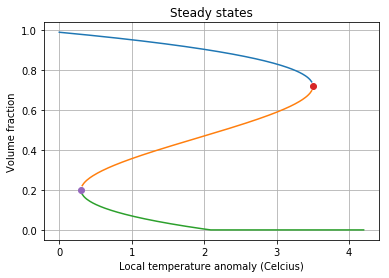

In [7]:
#-----------------------------------------------------        
# fixing steady states of double fold system: Tp,Tm,Vp,Vm
#-----------------------------------------------------        
fixDFsteady(3.5,0.3,0.72,0.2)

In [8]:
# trying the NextFunction
climate_state = [2000, Mat2000, Mup2000, Mlo2000, 0.1, 0.1, 1]
current_CO2_emission_rate = 9 
current_aerosol_injection_rate = 0 
current_CO2_emission_rate_change = 2
y = ( increase , high)
NextFunction(0, (0, climate_state, current_CO2_emission_rate, current_aerosol_injection_rate, current_CO2_emission_rate_change ), y)

(0,
 [2009.999999999991,
  904.51179300977162,
  731.40115683706938,
  35650.087050153161,
  -0.59638166883792421,
  0.082977394029847981,
  1.000074782213344],
 11,
 80,
 2)